In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
display(train_df.head())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
print("nData info:")
train_df.info()

nData info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
def preprocess_data(df, is_training=True):
    df = df.copy()
    df[['Deck', 'Cabin_num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
    df[numeric_features] = SimpleImputer(strategy='median').fit_transform(df[numeric_features])
    df[categorical_features] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_features])
    for col in categorical_features:
        df[col] = LabelEncoder().fit_transform(df[col])
    df['TotalSpending'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    df = df.drop(['Name', 'Cabin', 'Cabin_num', 'PassengerId'], axis=1)
    if is_training:
        df['Transported'] = df['Transported'].astype(int)
    return df

In [8]:
train_processed = preprocess_data(train_df, is_training=True)
test_processed = preprocess_data(test_df, is_training=False)

In [9]:
train_processed.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side,TotalSpending
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0.0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5,1,736.0
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,10383.0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,5176.0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5,1,1091.0


In [10]:
test_processed.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side,TotalSpending
0,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,6,1,0.0
1,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,5,1,2832.0
2,1,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0,2,1,0.0
3,1,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2,1,7418.0
4,0,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0,5,1,645.0


In [11]:
X = train_processed.drop('Transported', axis=1)
y = train_processed['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='logloss',
    early_stopping_rounds=20,
    verbose=False
)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       861
           1       0.78      0.83      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



<Figure size 1000x600 with 0 Axes>

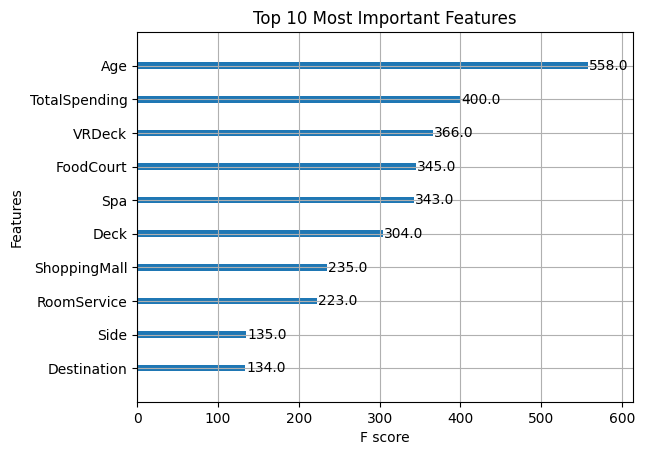

In [13]:
val_preds = model.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, val_preds))
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, title='Top 10 Most Important Features')
plt.show()

In [14]:
preds = model.predict(test_processed)
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': preds.astype(bool)
})
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [15]:
submission.to_csv('submission.csv', index=False)
print("Submission file has been created!")

Submission file has been created!
